In [ ]:
import json
import pandas as pd
import re
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
# Open and read the JSON file  https://huggingface.co/datasets/liuhaotian/LLaVA-Pretrain
with open("blip_laion_cc_sbu_558k.json", "r") as file:
    data = json.load(file)  # Parse the JSON data into a Python dictionary

# Convert to DataFrame
df = pd.DataFrame([{
    'id': item['id'],
    'img_path': 'images/'+item['image'],
    'input_text': next(conv['value'] for conv in item['conversations'] if conv['from'] == 'human'),
    'target_text': next(conv['value'] for conv in item['conversations'] if conv['from'] == 'gpt')
} for item in data]).dropna().reset_index(drop=True)

del(data)

df

,id,img_path,input_text,target_text
0,004539375,images/00453/004539375.jpg,Render a clear and concise summary of the phot...,select luxury furniture 3 - inch gel memory fo...
1,002239345,images/00223/002239345.jpg,Write a terse but informative summary of the p...,a grey watch with an army style strap
2,005947502,images/00594/005947502.jpg,<image>\nWhat is this?,a dragon kite flying in the blue sky stock images
3,005116462,images/00511/005116462.jpg,<image>\nRender a clear and concise summary of...,$ 10 - cute cheap printed mini dress - khaki m...
4,002017886,images/00201/002017886.jpg,What is in the photo?\n<image>,augmented reality using aruco markers in opencv
...,...,...,...,...
558123,000524806,images/00052/000524806.jpg,<image>\nRender a clear and concise summary of...,paper quilled letters of the alphabet h with c...
558124,003755035,images/00375/003755035.jpg,<image>\nShare a concise interpretation of the...,"a jabra corded headset with usb sync, power co..."
558125,002176227,images/00217/002176227.jpg,<image>\nWhat is in the photo?,"an apple ii computer, with a computer monitor ..."
558126,000600956,images/00060/000600956.jpg,Provide a brief description of the given image...,us03498792 figure 1 from a patent drawing of a...


In [3]:
# 1) Text cleaning ------------------------------------------------------
def clean_text(text: str) -> str:
    """
    Remove HTML, normalize whitespace, preserve punctuation/numbers/casing.
    """
    # text = text.lower()
    text = re.sub(r'<image>', '', text, flags=re.IGNORECASE)
    text = re.sub(r'[^a-zA-Z0-9.,!?]+', ' ', text)
    text = text.replace('\r', ' ').replace('\n', ' ')
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

df['target_text'] = df['target_text'].apply(lambda x: clean_text(x))
df['input_text'] = df['input_text'].apply(lambda x: clean_text(x))

In [4]:
# Combine summary + dialogue and split on whitespace
raw_lens = [
    len(f"{s} {d}".split()) 
    for s, d in tqdm(zip(df['target_text'], df['input_text']), total=len(df))
]

lens = np.array(raw_lens)

# Print summary stats
def pct(x): return np.percentile(lens, x)

print(f"Total examples    : {len(lens):,}")
print(f"Min / Max words   : {lens.min()} / {lens.max()}")
print(f"Mean ± std        : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- Percentiles (word count per raw text pair) ---")
for p in [50, 90, 95, 98, 99]:
    print(f"{p:>3}% : {pct(p):.0f} words")

del(raw_lens)

100%|██████████| 558128/558128 [00:00<00:00, 1419880.56it/s]


Total examples    : 558,128
Min / Max words   : 3 / 31
Mean ± std        : 17.1 ± 4.6
--- Percentiles (word count per raw text pair) ---
 50% : 17 words
 90% : 23 words
 95% : 25 words
 98% : 27 words
 99% : 29 words


In [5]:
MAX_LEN = int(pct(99))

text_pairs = []

for img,i,j in zip(df.img_path,df.input_text,df.target_text):
    try:
        if len(i.split(" ")+j.split(" ")) < MAX_LEN: 
            text_pairs.append((img,i,j))
    except:
        pass

len(text_pairs), text_pairs[:5]

(552415,
 [('images/00453/004539375.jpg',
   'render a clear and concise summary of the photo.',
   'select luxury furniture 3 inch gel memory foam mattress topper'),
  ('images/00223/002239345.jpg',
   'write a terse but informative summary of the picture.',
   'a grey watch with an army style strap'),
  ('images/00594/005947502.jpg',
   'what is this?',
   'a dragon kite flying in the blue sky stock images'),
  ('images/00511/005116462.jpg',
   'render a clear and concise summary of the photo.',
   '10 cute cheap printed mini dress khaki multicolor striped floral print peasant short sleeve tunic'),
  ('images/00201/002017886.jpg',
   'what is in the photo?',
   'augmented reality using aruco markers in opencv')])

In [6]:
import tensorflow as tf
from transformers import TFViTModel, ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("facebook/deit-tiny-patch16-224")
IMAGE_MEAN = tf.constant(processor.image_mean) # e.g., [0.485, 0.456, 0.406]
IMAGE_STD = tf.constant(processor.image_std)   # e.g., [0.229, 0.224, 0.225]
TARGET_SIZE = (processor.size["height"], processor.size["width"]) # e.g., (224, 224)

IMAGE_MEAN,IMAGE_STD,TARGET_SIZE

/Users/saptarshimallikthakur/Desktop/Extraas/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-09 10:17:31.273738: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-06-09 10:17:31.273873: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-06-09 10:17:31.273913: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
I0000 00:00:1749444451.274459 5329405 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749444451.274784 5329405 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: 

(<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 0.5, 0.5], dtype=float32)>,
 <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.5, 0.5, 0.5], dtype=float32)>,
 (224, 224))

In [7]:
def decode_and_resize(image_path):
    """
    A pure TensorFlow function for loading and preprocessing an image for ViT.
    This function can be efficiently parallelized in a tf.data pipeline.
    """
    # 1. Read and Decode Image (Fast TF I/O)
    img_bytes = tf.io.read_file(image_path)
    # Use decode_image to handle both JPEG and PNG robustly
    img = tf.image.decode_image(img_bytes, channels=3, expand_animations=False)
    
    # 2. Resize Image (Fast TF op)
    # The 'bicubic' method is standard for ViT models.
    img = tf.image.resize(img, TARGET_SIZE, method='bicubic')
    
    # 3. Convert dtype and rescale to [0, 1] (Fast TF op)
    # This replaces the internal scaling of the processor.
    img = tf.image.convert_image_dtype(img, dtype=tf.float32)
    
    # 4. Normalize using the model's specific mean and std (Fast TF op)
    img = (img - IMAGE_MEAN) / IMAGE_STD
    
    # 5. Transpose channels for the model (Fast TF op)
    # ViT models expect (channels, height, width), but TF loads as (height, width, channels).
    img = tf.transpose(img, perm=[2, 0, 1])
    
    return img

class ViTFeatureExtractor(tf.keras.layers.Layer):
    def __init__(self, model_name="facebook/deit-tiny-patch16-224"):
        super().__init__()
        self.vit = TFViTModel.from_pretrained(model_name)
        self.vit.trainable = False

    def call(self, pixel_values):
        outputs = self.vit(pixel_values)
        
        # Remove the [CLS] token
        patch_tokens = outputs.last_hidden_state[:, 1:, :]
        return patch_tokens                              

paths = tf.constant(['/Users/saptarshimallikthakur/Desktop/d39c160d9ed1a406519e4915c4b43e05.jpg','/Users/saptarshimallikthakur/Desktop/510afe0f8b983dfbd7b6c066b94135d2.jpg'])
images = tf.map_fn(decode_and_resize, paths, fn_output_signature=tf.float32)
model = ViTFeatureExtractor()
v3_output = model(images)
v3_output.shape

Some layers from the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


TensorShape([2, 196, 192])

In [8]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer
from tokenizers.processors import TemplateProcessing
from tokenizers import models, trainers, pre_tokenizers

1000



2000



4000



6000



8000



10000



12000





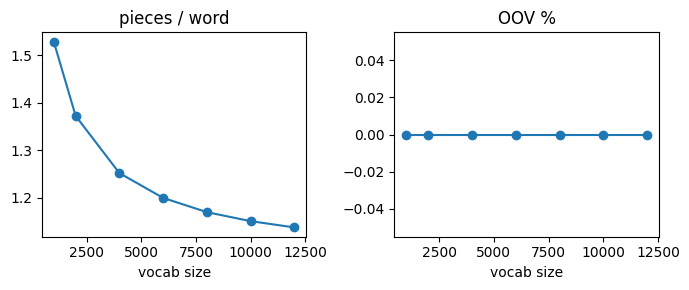

In [9]:
# ── assume train_df already loaded ─────────────────────────────────────
rng            = np.random.default_rng(42)
valid_mask     = rng.random(len(df)) < 0.25          # 25 % hold-out
train_df_, valid_df = df[~valid_mask], df[valid_mask]

# ⇢ cache validation texts so we can loop over them many times
valid_texts = [f"{s} {d}" for s, d in zip(valid_df["input_text"], valid_df["target_text"])]

def train_tokenizer(text_iter, vocab_size: int) -> Tokenizer:
    tok = Tokenizer(models.BPE(unk_token="[UNK]"))
    tok.pre_tokenizer = pre_tokenizers.Whitespace()
    trainer = trainers.BpeTrainer(vocab_size=vocab_size,
                                  min_frequency=2,
                                  special_tokens=["[UNK]"])
    tok.train_from_iterator(text_iter, trainer)
    return tok

def avg_pieces_per_word(tok: Tokenizer, texts) -> float:
    pieces = words = 0
    for t in texts:
        ids   = tok.encode(t).ids
        pieces += len(ids)
        words  += len(t.split())
    return pieces / words

vocab_sizes = [1000,2000,4000,6000,8000,10000,12000]
pieces_per_word, oov_rate = [], []

for k in vocab_sizes:
    print(k)
    train_iter = (f"{s} {d}" for s, d in
                  zip(train_df_["input_text"], train_df_["target_text"]))
    tok = train_tokenizer(train_iter, k)

    # 1) average sub-words per word on validation set
    pieces_per_word.append(avg_pieces_per_word(tok, valid_texts))

    # 2) OOV percentage on validation set
    unk_id = tok.token_to_id("[UNK]")
    total = unk = 0
    for t in valid_texts:
        ids   = tok.encode(t).ids
        total += len(ids)
        unk   += sum(id_ == unk_id for id_ in ids)
    oov_rate.append(100 * unk / total)

# ── plot ───────────────────────────────────────────────────────────────
plt.figure(figsize=(7,3))

plt.subplot(1,2,1)
plt.plot(vocab_sizes, pieces_per_word, marker='o')
plt.title("pieces / word"); plt.xlabel("vocab size")

plt.subplot(1,2,2)
plt.plot(vocab_sizes, oov_rate, marker='o')
plt.title("OOV %"); plt.xlabel("vocab size")

plt.tight_layout(); plt.show()

100%|██████████| 558128/558128 [00:13<00:00, 40613.03it/s]


Total samples    : 558,128
Min / Max tokens : 6 / 79
Mean ± std       : 21.9 ± 5.4
--- percentiles (tokens) ---
 50% : 21
 90% : 29
 95% : 32
 98% : 34
 99% : 36


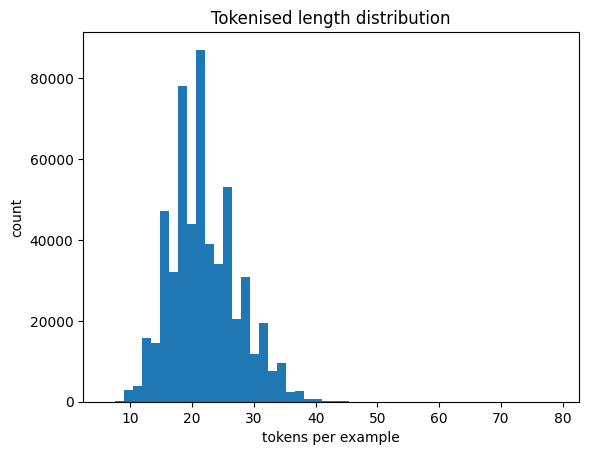

In [10]:
VOCAB_SIZE = 8000

CORPUS_FILE = 'all_texts.txt'
SPECIAL_TOKENS = ['[PAD]','[UNK]','[BOS]','[EOS]','[SEP]','[IMG_TOKEN]'] 

with open(CORPUS_FILE, 'w', encoding='utf-8') as f:
    for _, row in df.iterrows():
        f.write(str(row['input_text']) + ' ' + str(row['target_text']) + '\n')

# Initialize and train
tokenizer = Tokenizer(BPE(unk_token='[UNK]'))
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(vocab_size=VOCAB_SIZE, special_tokens=SPECIAL_TOKENS)
tokenizer.train([CORPUS_FILE], trainer)

# 3) Configure post-processing, padding & truncation ------------------
pad_id = tokenizer.token_to_id('[PAD]')
unk_id = tokenizer.token_to_id('[UNK]')
bos_id = tokenizer.token_to_id('[BOS]')
eos_id = tokenizer.token_to_id('[EOS]')
sep_id = tokenizer.token_to_id('[SEP]')
img_token_id = tokenizer.token_to_id('[IMG_TOKEN]')

# Add BOS/EOS around single sequences
tokenizer.post_processor = TemplateProcessing(
    single='[BOS] $A [SEP]',
    pair='[BOS] $A [SEP] $B [EOS]',
    special_tokens=[('[BOS]', bos_id), ('[EOS]', eos_id),('[SEP]', sep_id)]
)

# 0)  Make sure `tok` points to the FINAL tokenizer
#     → trained on the full corpus with your chosen vocab_size
# ------------------------------------------------------------
tok = tokenizer          # whatever variable you use

# ------------------------------------------------------------
# 1)  Get token counts for every example
#     (here: concatenate summary + dialogue; split if you want)
# ------------------------------------------------------------
lens = []

for s, d in tqdm(zip(df["input_text"], df["target_text"]),total=len(df)):
    txt   = f"{s} {d}"
    ids   = tok.encode(txt).ids
    lens.append(len(ids))

lens = np.array(lens)

# ------------------------------------------------------------
# 2)  Print key stats
# ------------------------------------------------------------
def pct(x): return np.percentile(lens, x)

print(f"Total samples    : {len(lens):,}")
print(f"Min / Max tokens : {lens.min()} / {lens.max()}")
print(f"Mean ± std       : {lens.mean():.1f} ± {lens.std():.1f}")
print("--- percentiles (tokens) ---")
for p in (50, 90, 95, 98, 99):
    print(f"{p:>3}% : {pct(p):.0f}")

# ------------------------------------------------------------
# 3)  Quick histogram    (no seaborn, single plot, no colors set)
# ------------------------------------------------------------
plt.hist(lens, bins=50)
plt.xlabel("tokens per example")
plt.ylabel("count")
plt.title("Tokenised length distribution")
plt.show()

In [11]:
BATCH_SIZE = 64
MAX_LEN = int(pct(99))
del(lens)

# 0) Configure your tokenizer *once* at startup, not per-example
tokenizer.enable_truncation(
    max_length=MAX_LEN
)

tokenizer.enable_padding(
    pad_id=pad_id,
    pad_token='[PAD]',
    length=MAX_LEN
)

def encode_text(texts):
    encodings = [img_token_id]*v3_output.shape[1] + tokenizer.encode(texts).ids
    return np.array(encodings, dtype=np.int32)

# 1) encode_pair → return a NumPy array
def encode_pair(text_a: str, text_b: str) -> np.ndarray:
    enc = [img_token_id]*v3_output.shape[1] + tokenizer.encode(text_a, text_b).ids
    return np.array(enc, dtype=np.int32)   # shape: [MAX_LEN]

def encode_example(img_path, text: str, summary: str):
    ids = encode_pair(text, summary)           # np.ndarray, shape=[MAX_LEN]
    labels = np.concatenate([ids[1:], [pad_id]])  # shape=[MAX_LEN]

    # find SEP
    sep_idxs = np.where(labels == sep_id)[0]
    sep_pos = int(sep_idxs[0]) if sep_idxs.size else len(ids)

    # build base mask: 1 only for positions > sep_pos AND not PAD
    positions = np.arange(len(labels))
    loss_mask = (positions > sep_pos).astype(np.float32) * (labels != pad_id).astype(np.float32)

    return img_path, ids, labels.astype(np.int32), loss_mask

# ── 0. do *all* tokenisation once ──────────────────────────
triples = [encode_example(img, t, s) for (img, t, s) in text_pairs]   # Python loop, done **once**
img_path, ids, labels, masks = map(lambda k: tf.constant(np.stack(k, 0)),zip(*triples))                      # shapes [N, MAX_LEN]

# ── 1. build the purely-TF dataset ─────────────────────────
ds = (
    tf.data.Dataset.from_tensor_slices({'img_path':img_path,"input_ids": ids, "labels": labels, "loss_mask": masks})
    .shuffle(len(text_pairs))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

del(triples)
del(img_path)
del(ids)
del(labels)
del(masks)

In [12]:
vocab = tokenizer.get_vocab()           # indices 0 … V

id_to_token = {idx: tok for tok, idx in vocab.items()}

# 2) Decoder: drop PADs
def decode_token_ids(token_ids: list[int]) -> str:
    tokens = []
    for tid in token_ids:
        if tid == pad_id:
            continue
        tok = id_to_token.get(tid, '?')
        if tok == '$':
            continue  # Skip the '$' symbol
        if tok.startswith('Ġ'):
            tok = tok[1:]  # Remove the space prefix indicator
            tokens.append(' ' + tok)
        else:
            tokens.append(tok)
    return ' '.join(tokens).strip()

# 3) Inspect one batch from your TF dataset"
for batch in ds.take(10):
    pth = batch['img_path'].numpy()
    input_ids = batch['input_ids'].numpy()  # shape (batch, MAX_LEN)
    labels    = batch['labels'].numpy()

    for i, (pth, ids_row, lbl_row) in enumerate(zip(pth, input_ids, labels), start=1):
        print(f"\n🟢 Sample {i}")
        print("  pth: ", pth)
        print("  Input IDs: ", ids_row.tolist())
        print("  Decoded:   ", decode_token_ids(ids_row.tolist()))
        print("  Label IDs: ", lbl_row.tolist())


🟢 Sample 1
  pth:  b'images/00454/004540931.jpg'
  Input IDs:  [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 117, 19, 116, 96, 51, 46, 63, 7, 4, 2478, 5569, 1045, 15, 247, 34, 495, 53, 34, 1683, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  Decoded:    [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG

2025-06-09 10:19:17.536385: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [13]:
for batch in ds.take(1):
    break
    
j=19
print(batch["loss_mask"][j])
print('\n',decode_token_ids(batch["labels"][j].numpy()))

tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(232,), dtype=float32)

 [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN] [IMG_TOKEN

In [14]:
batch['input_ids']

<tf.Tensor: shape=(64, 232), dtype=int32, numpy=
array([[5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       ...,
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0],
       [5, 5, 5, ..., 0, 0, 0]], dtype=int32)>

# LLAMA

In [15]:
def apply_rope(x, sin, cos):
    """
    x   : (B, h, T, d) even-sized last dim (d must be multiple of 2)
    sin : (T, d//2)     broadcastable
    cos : (T, d//2)
    """
    #This separates each feature vector's dimensions into 2 halves — like real and imaginary parts.
    x_even = x[..., 0::2]      # Get even-dimension values → shape: (B, h, T, d/2)
    x_odd  = x[..., 1::2]      # Get odd-dimension values → shape: (B, h, T, d/2)

    # This is a 2D rotation formula applied to each positional index and head.
    # It "rotates" the embedding vector in its dimensional space based on position.
    x_rot_even =  x_even *  cos - x_odd * sin
    x_rot_odd  =  x_even *  sin + x_odd * cos
    
    # interleave even/odd back together
    x_rot = tf.stack([x_rot_even, x_rot_odd], axis=-1)   # (..., d/2, 2)
    return tf.reshape(x_rot, tf.shape(x))                # (..., d)

def make_sincos(seq_len, dim, base=10000):
    '''
    Returns sin, cos with shape (seq_len, dim//2)
    '''
    pos = tf.cast(tf.range(seq_len), tf.float32)                       # (T,)
    i   = tf.cast(tf.range(0, dim, 2), tf.float32) / dim              # (d/2,)
    theta = pos[:, None] / (base ** i[None, :])                       # (T, d/2)
    return tf.sin(theta), tf.cos(theta)

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Vanilla multi-head (scaled-dot-product) attention implemented from scratch.

    Args
    ----
    d_model     : int   – total embedding size (must be divisible by num_heads)  
    num_heads   : int   – number of attention heads  
    dropout     : float – dropout on attention weights (0.0 = no dropout)

    Call Signature
    --------------
    output, attn_scores = mha(
        query,                     # (B, T_q, d_model)
        value=None,                # (B, T_v, d_model)  – defaults to query
        key=None,                  # (B, T_k, d_model)  – defaults to value
        mask=None,                 # (B, 1, T_q, T_k) or (B, T_q, T_k)
        use_causal_mask=False,     # True → autoregressive causal mask
        training=None
    )
    """
    def __init__(self, d_model, num_heads, dropout=0.0, **kwargs):
        super().__init__(**kwargs)
        if d_model % num_heads != 0:
            raise ValueError(
                f"d_model={d_model} must be divisible by num_heads={num_heads}"
            )

        self.d_model   = d_model
        self.num_heads = num_heads
        self.depth     = d_model // num_heads

        # Linear projections for Q, K, V and final output
        self.wq   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wk   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wv   = tf.keras.layers.Dense(d_model, use_bias=False)
        self.wo   = tf.keras.layers.Dense(d_model, use_bias=False)

        self.dropout = tf.keras.layers.Dropout(dropout)

    # ────────────────────────────────────────────────────────────────────────
    # Helpers
    # ────────────────────────────────────────────────────────────────────────
    def _split_heads(self, x, B):
        """
        Reshape (B, T, d_model) → (B, num_heads, T, depth)
        so we can run attention on each head in parallel.
        """
        x = tf.reshape(x, (B, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    @staticmethod
    def _scaled_dot_product_attention(q, k, v, mask, dropout,training=None):
        """
        Core attention: softmax(QKᵀ / √d_k) V
        Returns: (B, h, T_q, depth_v), (B, h, T_q, T_k)
        """
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)  # (B,h,T_q,T_k)

        if mask is not None:
            # broadcast automatically if mask rank < scores rank
            scores += (mask * -1e9)  # large negative → zero probability

        attn = tf.nn.softmax(scores, axis=-1)
        attn = dropout(attn,training=training)
        output = tf.matmul(attn, v)  # (B,h,T_q,depth)
        return output

    # ────────────────────────────────────────────────────────────────────────
    # Forward pass
    # ────────────────────────────────────────────────────────────────────────
    def call(
        self,
        query,
        value=None,
        key=None,
        mask=None,
        use_causal_mask=False,
        training=None
    ):
        if value is None:
            value = query
        if key is None:
            key = value

        B = tf.shape(query)[0]
        Tq = tf.shape(query)[1]          # sequence length of Q
        Tk = tf.shape(key)[1]

        # 1. Linear projections
        q = self.wq(query)   # (B, T_q, d_model)
        k = self.wk(key)     # (B, T_k, d_model)
        v = self.wv(value)   # (B, T_v, d_model)

        # 2. Reshape for multi-head
        q = self._split_heads(q, B)  # (B, h, T_q, depth)
        k = self._split_heads(k, B)  # (B, h, T_k, depth)
        v = self._split_heads(v, B)  # (B, h, T_v, depth)

        # 3) -----------------  ROTARY  -----------------
        # Build sin/cos for the longest sequence we need this step
        max_len = tf.maximum(Tq, Tk)
        sin, cos = make_sincos(max_len, self.depth)       # depth = d_model / num_heads

        # Slice sin/cos to actual lengths (broadcast works automatically)
        # RoPE modifies Q and K such that their dot product reflects not just content similarity but also relative position.
        q = apply_rope(q, sin[:Tq], cos[:Tq])             # rotate Q
        k = apply_rope(k, sin[:Tk], cos[:Tk])             # rotate K
        # ----------------------------------------------

        # 3. (Optional) Causal mask: block future positions
        if use_causal_mask:
            T_q = tf.shape(q)[2]
            T_k = tf.shape(k)[2]
            causal = 1.0 - tf.linalg.band_part(tf.ones((T_q, T_k)), -1, 0)  # lower-tri  # 1 → masked
            causal = causal[tf.newaxis, tf.newaxis, :, :]  # (1,1,T_q,T_k)
            mask = causal if mask is None else tf.maximum(mask, causal)

        # 4. Scaled dot-product attention
        attn_out = self._scaled_dot_product_attention(
            q, k, v, mask, self.dropout,training=training,
        )  # (B,h,T_q,depth), (B,h,T_q,T_k)

        # 5. Concatenate heads
        attn_out = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (B,T_q,h,depth)
        attn_out = tf.reshape(attn_out, (B, -1, self.d_model))  # (B,T_q,d_model)

        # 6. Final linear layer
        output = self.wo(attn_out)  # (B,T_q,d_model)

        return output
    
class RMSNorm(tf.keras.layers.Layer):
    def __init__(self, hidden_size, epsilon=1e-8, **kwargs):
        super(RMSNorm, self).__init__(**kwargs)
        self.hidden_size = hidden_size
        self.epsilon = epsilon
        
        # Learnable scale parameter γ (same shape as last dim of input)
        self.scale = self.add_weight(
            name="scale",
            shape=(self.hidden_size,),
            initializer="ones",
            trainable=True
        )

    def call(self, x):
        rms = tf.sqrt(tf.reduce_mean(tf.square(x), axis=-1, keepdims=True) + self.epsilon)
        norm_x = x / rms
        return norm_x * self.scale

class CausalSelfAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, dropout=0.0):
        super().__init__()
        self.mha = MultiHeadAttention(d_model=d_model,num_heads=num_heads,dropout=dropout)
        self.rmsnorm = RMSNorm(d_model)
        self.add = tf.keras.layers.Add()

    def call(self, x, padding_mask=None, training=None):

        rms_x1 = self.rmsnorm(x)
        attn_output = self.mha(
            query=rms_x1, value=rms_x1, key=rms_x1,
            mask=padding_mask,          # may be None
            use_causal_mask=True,
            training=training,
        )
        rms_x1 = self.add([x, attn_output])
        return rms_x1
    
class SwiGLU(tf.keras.layers.Layer):
    def __init__(self, hidden_dim,factor=4):
        super().__init__()
        self.lin1 = tf.keras.layers.Dense(factor*hidden_dim,use_bias=False)   # W1
        self.lin2 = tf.keras.layers.Dense(hidden_dim,use_bias=False)       # W2

    def call(self, x):
        x_ = self.lin1(x)                          # shape: (..., 4d)
        a, b = tf.split(x_, num_or_size_splits=2, axis=-1)  # split
        gated = a * (b * tf.sigmoid(b))            # SwiGLU: a ⊙ SiLU(b)
        return self.lin2(gated)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super().__init__()

        self.seq = tf.keras.Sequential(
            [
                SwiGLU(d_model),
                tf.keras.layers.Dropout(dropout_rate),
            ]
        )
        self.rmsnorm = RMSNorm(d_model)

    def call(self, x, training=None):
        y = self.seq(self.rmsnorm(x), training=training)  # pre-norm
        return x + y                                  # residual on raw x
    
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, *, d_model, num_heads, dropout_rate=0.1):
        super().__init__()
        self.causal_self_attention = CausalSelfAttention(num_heads=num_heads, d_model=d_model, dropout=dropout_rate)
        self.ffn = FeedForward(d_model)

    def call(self, x, padding_mask=None, training=None):
        x = self.causal_self_attention(x, padding_mask=padding_mask, training=training)
        x = self.ffn(x,training=training)
        return x

In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(
        self, *, num_layers, d_model, num_heads, dropout_rate=0.1,pad_token_id = pad_id):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.pad_token_id = pad_token_id

        self.token_embedding = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE,output_dim=d_model)
        self.img_embedding = ViTFeatureExtractor()
        
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        
        self.dec_layers = [DecoderLayer(d_model=d_model, num_heads=num_heads, dropout_rate=dropout_rate) for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, inputs, training=None):
        pad_mask = tf.cast(tf.equal(inputs[1], self.pad_token_id), tf.float32)[:, tf.newaxis, tf.newaxis, :]

        img = self.img_embedding(inputs[0])
        text = self.token_embedding(inputs[1])

        # Make sure img_emb has the same dtype as text_emb
        img = tf.cast(img, dtype=text.dtype)

        # Replace text[:, 0, :] with img_emb
        x = tf.concat([img, text[:, v3_output.shape[1]:, :]], axis=1)
        x = self.dropout(x, training=training)

        for layer in self.dec_layers:
            x = layer(x, padding_mask=pad_mask, training=training)
        return x
    
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, input_vocab_size, dropout_rate=0.1):
        super().__init__()

        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dropout_rate=dropout_rate,
        )

        self.rmsnorm = RMSNorm(d_model)
        self.final_layer = tf.keras.layers.Dense(input_vocab_size)

    def call(self, inputs,training=False):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        x = inputs

        x = self.decoder(x,training=training)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        x = self.rmsnorm(x)
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

In [17]:
v3_output.shape[-1],v3_output.shape[-1]/32

(192, 6.0)

In [18]:
num_layers = 6
d_model = v3_output.shape[-1]
num_heads = v3_output.shape[-1]//32
dropout_rate = 0.1
EPOCHS = 2

model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    input_vocab_size=VOCAB_SIZE,
    dropout_rate=0.1
)

dummy_path   = tf.constant(["/Users/saptarshimallikthakur/Desktop/d39c160d9ed1a406519e4915c4b43e05.jpg"])   # (1,)  string
images = tf.map_fn(decode_and_resize, dummy_path, fn_output_signature=tf.float32)
dummy_tokens = tf.zeros((1, MAX_LEN+v3_output.shape[1]), dtype=tf.int32)
_ = model((images, dummy_tokens))              
model.summary()

Some layers from the model checkpoint at facebook/deit-tiny-patch16-224 were not used when initializing TFViTModel: ['classifier']
- This IS expected if you are initializing TFViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFViTModel were not initialized from the model checkpoint at facebook/deit-tiny-patch16-224 and are newly initialized: ['vit/pooler/dense/kernel:0', 'vit/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder (Decoder)               │ ?                      │     3,750,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rms_norm_12 (RMSNorm)           │ ?                      │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (1, 232, 8000)         │     1,544,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,294,336 (20.20 MB)

 Trainable params: 5,294,336 (20.20 MB)

 Non-trainable params: 0 (0.00 B)

tf.Tensor(
[1.0000000e-06 1.0000000e-06 1.0000000e-06 ... 4.3231885e-06 4.3220612e-06
 4.3209347e-06], shape=(17262,), dtype=float32)


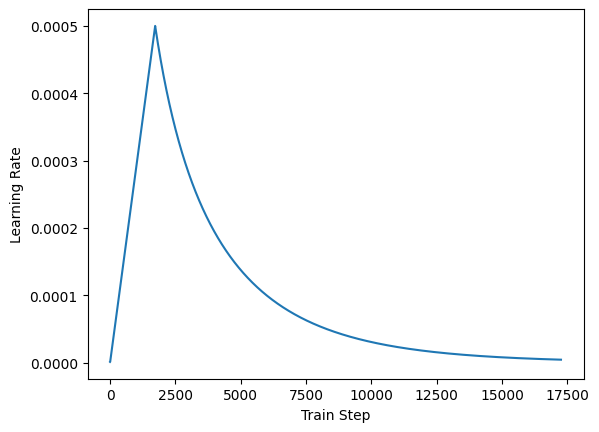

In [19]:
WARM_FRAC   = 0.1        # keep the fast ramp-up
DECAY_RATE  = 4
LR_FLOOR    = 1e-6
LR_PEAK_DESIRED = 5e-4     # choose 8e-4 or 9e-4

# pre-compute the scale that gives that peak
num_steps     = EPOCHS * len(text_pairs) // BATCH_SIZE
warmup_steps  = int(num_steps * WARM_FRAC)
current_peak  = 1.0 / tf.sqrt(tf.cast(d_model * warmup_steps, tf.float32))
LR_SCALE      = LR_PEAK_DESIRED / current_peak.numpy()

@tf.keras.utils.register_keras_serializable()   # so it can round-trip in SavedModel/H5
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, total_steps=num_steps,
                 warmup_frac=WARM_FRAC, decay_rate=DECAY_RATE,
                 lr_scale=LR_SCALE):
        super().__init__()
        self.d_model      = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(int(total_steps * warmup_frac), tf.float32)
        self.decay_rate   = decay_rate
        self.decay_steps  = tf.cast(total_steps, tf.float32)
        self.lr_scale     = tf.cast(lr_scale, tf.float32)

    def __call__(self, step):
        step  = tf.cast(step, tf.float32)
        arg1  = tf.math.rsqrt(step)
        arg2  = step * tf.math.pow(self.warmup_steps, -1.5)
        warm  = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        decay = tf.math.exp(-self.decay_rate *
                            tf.maximum(step - self.warmup_steps, 0.) /
                            self.decay_steps)
        lr = warm * decay * self.lr_scale 
        return tf.maximum(lr, LR_FLOOR)

    # ----------  NEW  ----------
    def get_config(self):
        return {
            "d_model":      int(self.d_model.numpy()),   # cast back to Python types
            "total_steps":  int(self.decay_steps.numpy()),
            "warmup_frac":  float(self.warmup_steps.numpy() / self.decay_steps.numpy()),
            "decay_rate":   self.decay_rate,
            "lr_scale":     float(self.lr_scale.numpy()),
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=1.0)

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(num_steps, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

print(temp_learning_rate_schedule(tf.range(num_steps, dtype=tf.float32)))

In [20]:
ds_for_fit = ds.map(
    lambda b: (
        (tf.map_fn(decode_and_resize, b['img_path'], fn_output_signature=tf.float32), b["input_ids"]),
        b["labels"],
        b["loss_mask"]
    ),
    num_parallel_calls=tf.data.AUTOTUNE
)

del(ds)

# 3) Compile with a standard sparse‐CE loss and let Keras use sample weights
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=None),
    metrics=["sparse_categorical_accuracy"]
)

# Build callbacks
callbacks = [
    EarlyStopping(monitor="loss", patience=3,
                  restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        filepath="best_summary.keras",        # or "best_summary.h5"
        monitor="loss",
        save_best_only=True,
        verbose=1             # full model (weights + optimizer + LR schedule)
    )
]

# 4) Fit!  Keras will print epoch/step progress by default
history = model.fit(
    ds_for_fit,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1    # 1 = progress bar, loss & acc per epoch
)

Epoch 1/2


2025-06-09 10:19:28.921876: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  15/8632 ━━━━━━━━━━━━━━━━━━━━ 3:43:09 2s/step - loss: 0.4819 - sparse_categorical_accuracy: 4.3456e-05

KeyboardInterrupt: 

In [ ]:
def encode(text: str) -> list[int]:
    """
    Encodes the prompt for inference, creating a sequence that ends
    right after the [SEP] token, with NO PADDING.
    """
    # 1. Temporarily disable padding on the tokenizer
    tokenizer.no_padding()
    
    # 2. Encode the text. The post-processor will add [BOS] and [SEP].
    # This will return: [BOS, id, id, ..., SEP]
    text_ids = tokenizer.encode(text).ids
    
    # 3. IMPORTANT: Re-enable padding for any other part of your code that might need it
    tokenizer.enable_padding(pad_id=pad_id, pad_token='[PAD]', length=MAX_LEN)
    
    # 4. Prepend the image placeholder tokens
    full_ids = [img_token_id] * v3_output.shape[1] + text_ids
    
    return full_ids

def generate_answer(image_path: str,
                    question:   str,
                    max_new_tokens: int = 100) -> str:
    
    img_token = tf.constant([image_path])
    img_token = tf.map_fn(decode_and_resize, img_token, fn_output_signature=tf.float32)
    
    # 1. Encode the prompt (image placeholders + question)
    # This creates: [IMG]...[IMG] [BOS] question [SEP]
    prompt_ids = encode(question)
    text_tokens = tf.constant([prompt_ids], dtype=tf.int32)
    
    # 2. Autoregressive loop
    for _ in range(max_new_tokens):
        # Use direct model call for performance (not model.predict)
        # Pass training=False
        logits = model((img_token, text_tokens), training=False)[:, -1, :] / 0.1
        
        # Sample the next token
        next_id = tf.random.categorical(logits, 1, dtype=tf.int32)

        # Append the new token
        text_tokens = tf.concat([text_tokens, next_id], 1)

        # Stop ONLY if EOS is generated
        if next_id[0, 0] == eos_id:
            break

    # 3. Decode the generated output
    generated_ids = text_tokens.numpy().tolist()[0] 
    
    # --- END FIX ---

    # Display image for context
    imgbgr = cv2.imread(image_path)
    if imgbgr is not None:
        imgrgb = cv2.cvtColor(imgbgr,cv2.COLOR_BGR2RGB)
        plt.imshow(imgrgb)
        plt.title(f"Q: {question}")
        plt.axis('off')
        plt.show()

    print(tokenizer.decode(generated_ids).strip())

In [ ]:
img   = "/Users/saptarshimallikthakur/Desktop/Screenshot 2025-06-08 at 7.36.42 AM.png"
ques  = "where is the dog ?"

generate_answer(img, ques)

In [ ]:
for j in range(10):
    print('\n',j)
    img   = df['img_path'][j]
    ques  = df['input_text'][j]
    gen = generate_answer(img, ques)
    print(gen)